In [24]:
# Notes to recompute power

# List CPMA pvals
# cat /gymreklab-tscc/cynthiawu/Test_nullsnps/simulate_eqtls_only/FastMultivariate/Single_eqtl/SampleSize100/SingleParameter/numTarget_0/Beta_0/Simulation_*/CPMA/gene-snp-eqtl_cpma_pvalues_fixed | grep -v snp | cut -f 4

# List mixture model pvals
# cat /gymreklab-tscc/cynthiawu/Test_nullsnps/simulate_eqtls_only/FastMultivariate/Single_eqtl/SampleSize100/SingleParameter/numTarget_0/Beta_0/Simulation_*/mixtureModel/gene-snp-eqtl_mixturepvalue  | grep -v snp | cut -f 2

# Get best pairwise SNPxgene pvals
# for f in $(ls /gymreklab-tscc/cynthiawu/Test_nullsnps/simulate_eqtls_only/FastMultivariate/Single_eqtl/SampleSize100/SingleParameter/numTarget_30/Beta_1/Simulation_*/CPMA/gene-snp-eqtl); do cat $f | grep -v gene | datamash min 5; done

# Make script to summarize p-vals for a given sample size, beta, target, method
# Run that to preprocess
# Then load those pvals to compute power

In [31]:
%%bash

OUTDIR=/storage/mgymrek/cpma/power/
SSIZE=500
TARGETS="5 15 20 30 40 60 80 100 150 200 250 300 350 400 450 500 700 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000"
BETAS="001 002 003 004 005 01 02 03 04 05 1"
RESDIR=/gymreklab-tscc/cynthiawu/Test_nullsnps/simulate_eqtls_only/FastMultivariate/Single_eqtl

for targets in $TARGETS
do
    for beta in $BETAS
    do
        # CPMA
        echo $targets $beta
        cat ${RESDIR}/SampleSize${SSIZE}/SingleParameter/numTarget_${targets}/Beta_${beta}/Simulation_*/CPMA/gene-snp-eqtl_cpma_pvalues_fixed | \
            grep -v snp | cut -f 4 > ${OUTDIR}/CPMA_${SSIZE}_${targets}_${beta}.pvals
        
        # Mixture model - TODO
        
        # Pairwise - TODO
    done
done

Process is interrupted.


In [1]:
%pylab inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [6]:
# Params and paths

targets = [ 5, 15, 20, 30, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500, 700, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000]
beta_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

sample_size = 100

In [8]:
# TODO change to read in summarized pvals
def get_power(targets, beta_values, fname, sample_size, label_name):
    power = []
    all_powers = []
    for beta in beta_values:
        for tar in targets:   
            value = str(beta).replace(".","")
            path = f'/gymreklab-tscc/cynthiawu/Test_nullsnps/simulate_eqtls_only/FastMultivariate/Single_eqtl/SampleSize{sample_size}/SingleParameter/numTarget_{tar}/Beta_{value}/{fname}'
            cur_file = pd.read_csv(path, sep='\t')
            power.append(float(cur_file['power_adjusted']))
        all_powers.append(power)
        power = []
    power_df = pd.DataFrame(all_powers, columns=targets, index=beta_values)
    return power_df

power_cpma_df = get_power(targets, beta_values, 'power_cpmax_1.0_adjusted.txt', sample_size, 'CPMA')
power_pairwise_df = get_power(targets, beta_values, 'power_matrix-eqtl_onesuccess.txt', sample_size, 'Pairwise')
#power_mixture_df = get_power(targets, beta_values, 'power_mixtureModel_adjusted.txt', sample_size, 'mixtureModel')

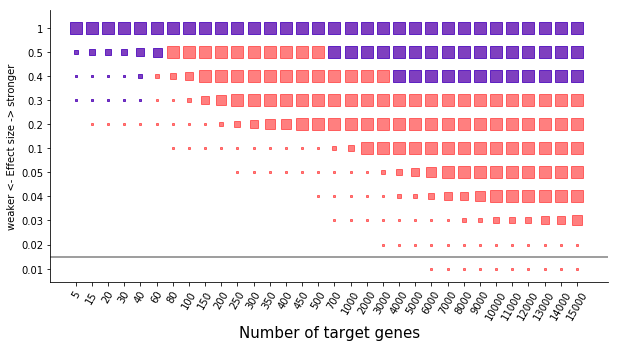

In [23]:
# Set up heatmap plotting

def DrawPoint(ax1, xval, yval, size, colors):
    if size > 0:
        for c in colors:
            ax1.scatter([xval], [yval], marker='s',
                   s=size, color=c, alpha=0.5)
    
def power_plot(power_dfs_dict, targets, beta_values):

    # First plot power
    size_scale = 1
    fig = plt.figure()
    fig.set_size_inches((10, 5))
    
    ax1 = fig.add_subplot(111)
    size = 150
    for xval in range(len(targets)):
        for yval in range(len(beta_values)):
            colors = []
            best_power = 0
            for method in power_dfs_dict.keys():
                power = power_dfs_dict[method]["power"][yval, xval]
                if power >= best_power:
                    best_power = power
                    colors.append(power_dfs_dict[method]["color"])
            DrawPoint(ax1, xval, yval, size*best_power, colors)
    ax1.set_xticks(range(len(targets)))
    ax1.set_xticklabels(targets, rotation=60)
    ax1.set_yticks(range(len(beta_values)))
    ax1.set_yticklabels(beta_values)
    ax1.set_xlabel("Number of target genes", size=15)
    ax1.set_ylabel("weaker <- Effect size -> stronger")
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')

    # Draw a line marking off beta=0, these can be interpreted as FPR
    ax1.axhline(y=0.5, color="gray")
    
power_dfs_dict = {
    "CPMA": {"power": np.matrix(power_cpma_df), "color": "red"},
#    "Mixture": {"power": np.matrix(power_mixture_df), "color": "yellow"},
    "Pairwise": {"power": np.matrix(power_pairwise_df), "color": "blue"}    
}

power_plot(power_dfs_dict, targets, beta_values)